# Exact diagonalization for Bose-Hubbard model

## Introduction

1D [Bose-Hubbard model](https://en.wikipedia.org/wiki/Bose%E2%80%93Hubbard_model) Hamiltonian has a following form:
$$
\hat{H} = J\sum_i\left(\hat{a}^\dag_{i+1}\hat{a}_i + h.c.\right) + \frac{U}{2}\sum_i\left(\hat{n}_i-1\right)\hat{n}_i
$$
where
- $J$ - hopping integral
- $U$ - on-site interaction
- $\hat{a}^\dag_i$, $\hat{a}_i$, $\hat{n}_i$ - creation, annihilation and particle number operators for site $i$

For large $U$ it describes Mott-insulator, for large $J$ it describes superfluid. For simplicity we will express energy in units of $U$, so the hopping will become $J/U$ and on-site interaction will be $1$.

### Implementation
The following is Python implementation of exact diagonalization method of Bose-Hubbard model that is based on [Exact diagonalization: the Bose–Hubbard model as an example](https://iopscience.iop.org/article/10.1088/0143-0807/31/3/016) by Zhang and Dong.

I made use of [CuPy](https://docs.cupy.dev/en/stable/) package to perform calculation on GPU. The requirements to run this notebook on GPU are:
1. Nvidia GPU with CUDA
2. Installing CUDA Toolkit - choose correct version [here](https://developer.nvidia.com/cuda-downloads) and follow the instructions

This notebook can also be run on CPU by changing `cupy` to `numpy` and removing `cupyx` from `scipy` imports.

## Imports

In [1]:
from itertools import combinations_with_replacement as cwr
from itertools import product

import cupy as cp
import matplotlib.pyplot as plt
from cupyx.scipy.sparse import coo_matrix
from cupyx.scipy.sparse.linalg import eigsh
from scipy.special import comb
from tqdm import tqdm # to display progress bar

## Parametrization
Typical usage is filling $\langle n_i\rangle=1$ which corresponds to `N==M`

In [2]:
M = 12 # number of sites
N = 12 # number of particles

In [3]:
D = comb(M, N, exact=True, repetition=True)
print(f"Size of a Hilbert space is {D}.")

D_1 = comb(M, N-1, exact=True, repetition=True) # number of states with non-zero number of particles at site i (each site is the same due to translational invariance)
next_site = cp.array([i + 1 for i in range(M)], dtype=int) # neet trick for getting next neighbours and periodic boundary conditions
next_site[M - 1] = 0

mempool = cp.get_default_memory_pool() # to be able to remove some redundant variables from GPU memory (running on CPU comment this line)

Size of a Hilbert space is 1352078.


## Setup
Where possible I tried to vectorize operations to take full advantage of GPU computing capabilites. For generation of kinetic part of the Hamiltonian I was able to go from 40 s in the initial implementation to 0.1 s in the optimized GPU implementation.

### Generate states

Although Zhang and Dong propose beautiful hierarchical algorithm for generation of the whole basis, `itertools` module provides method `combinations_with_replacement` which generates all multisets. $i^{\text{th}}$ element of these multisets correponds to site of an $i^{\text{th}}$ particle. Counting occurences of each site label gives us state in occupational basis.

In [4]:
states = []
for multiset in tqdm(cwr(range(M), N)):
    states.append([multiset.count(m) for m in range(M)])
states = cp.array(states)
print(f"Shape of a state vector is {states.shape}.")

1352078it [00:02, 639358.57it/s]


Shape of a state vector is (1352078, 12).


### Hashing trick
As proposed in the paper, I will use hashing function
$$T(v)=\sum\limits_{i=1}^M\sqrt{100\cdot i +3}\cdot A_{iv}$$
where $A_{iv}$ is occupation matrix `states`

In [5]:
weights = cp.sqrt(100 * cp.arange(1, M + 1) + 3)
T = states @ weights
ind = cp.arange(D, dtype=int) # keep these indices - they will be useful later
sorting_idx = cp.argsort(T)
T = T[sorting_idx]
ind_sorted = ind[sorting_idx]
eps = cp.diff(T).min()/10

def get_state_idx(state):
    global T, ind_sorted, weights, eps
    idx = cp.searchsorted(T, (state @ weights)-eps, 'left') # in order to ensure correct index I shifted resulted hash and enforced searching tags from the left side
    return ind_sorted[idx]                                  #   otherwise i or i+1 is a valid output - see np.searchsorted documentation for details

### Kinetic part of the Hamiltonian
- `values` - result of application of $\hat{a}^\dag_{i+1}\hat{a}_i$
- `idx_u` - indices of rows
- `idx_v` - indices of columns
- Non-zero elements of are determined by $i$. For each $i$ we can process whole `states` matrix at once leaving only non-zero elements for this given $i$.
- Subtracting $i^{\text{th}}$ and adding $(i+1)^{\text{th}}$ rows of `unit` matrix from `states` matrix gives the same effect moving particle from $i$ to $i+1$. This is made possible by the power of [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)
- hashing function gives us indices of columns efficiently

In [6]:
unit = cp.eye(M)
non_zero = (states != 0).T # transpose for easier handling
values = cp.zeros(D_1*M, dtype="float32") # D_1*M is number of non-zero elements
idx_u = cp.zeros_like(values)
idx_v = cp.zeros_like(values)

for i in tqdm(range(M)):
    start = i*D_1
    end = (i+1)*D_1
    values[start: end]= cp.sqrt((states[non_zero[i], next_site[i]] + 1) * states[non_zero[i], i])
    idx_u[start: end] = ind[non_zero[i]]
    idx_v[start: end] = get_state_idx(states[non_zero[i], :] - unit[i] + unit[next_site[i]])

100%|██████████| 12/12 [00:00<00:00, 117.95it/s]


Use sparse matrix since there will be only `2*D_1*M` non-zero elemnts.

In [7]:
H_kin = coo_matrix((values, (idx_u, idx_v)), shape=(D, D), dtype="float32")
H_kin = H_kin + H_kin.T

# free memory
del values, idx_u, idx_v
mempool.free_all_blocks()

Let's inspect pattern of non-zero elements. This is very useful tool which helped me debug why `np.searchsorted` didn't work how I expected it to work.

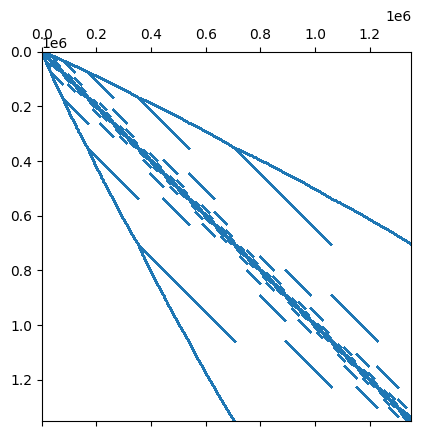

In [8]:
plt.spy(H_kin.get(), markersize=0.1)

### Interaction part of the Hamiltionan
This is fairly straightforward.

In [9]:
H_int = 0.5 * coo_matrix(
    (
        (states * (states - 1)).sum(axis=1).astype("float32"),
        (ind, ind),
    ),
    shape=(D, D),
)

## Calculations
Groundstate energy alone doesn't give us much information about the system (by itself). That's why we calculate density matrix 
$$\rho_{i,j} = \langle G\mid \hat{a}^\dag_{i}\hat{a}_j\mid G \rangle$$
where $\mid G\rangle$ is groundstate eigenvector.

Function `density_matrix` uses the same tricks as process of building kinetic part of the Hamiltonian. The only additional thing to note is that from the bra vector $\langle G\mid$ we need to choose states that have the same configuration as states in $\hat{a}^\dag_{i}\hat{a}_j\mid G \rangle$. We get indices of those states efficiently by using hashing function in `get_state_idx` method.

Using density matrix we can calculate condensate fraction
$$
f_c = \frac{\lambda_1}{N}
$$
where $\lambda_1$ is largest eigenvalue of $\rho$.

In [10]:
def density_matrix(vec):
    global M, states, unit, non_zero
    rho = cp.zeros((M, M))
    for i, j in product(range(M), range(M)):
        coef = cp.sqrt((states[non_zero[j], i] + 1) * states[non_zero[j], j])
        idx = get_state_idx(states[non_zero[j]] - unit[j] + unit[i])
        rho[i, j] = vec[idx, 0] @ (coef * vec[non_zero[j], 0])
    return rho

In [11]:
J_min = 0
J_max = 1
J_len = 50  # number of unique values of U in the range

J_vals = cp.linspace(J_min, J_max, num=J_len)
f_c = cp.zeros_like(J_vals)

for i, J in enumerate(tqdm(J_vals)):
    _, vec = eigsh(H_int + J * H_kin, k=1, which="SA", return_eigenvectors=True)
    rho = density_matrix(vec)
    lamb = cp.linalg.eigvalsh(rho)[-1]
    f_c[i] = lamb / N

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


## Results

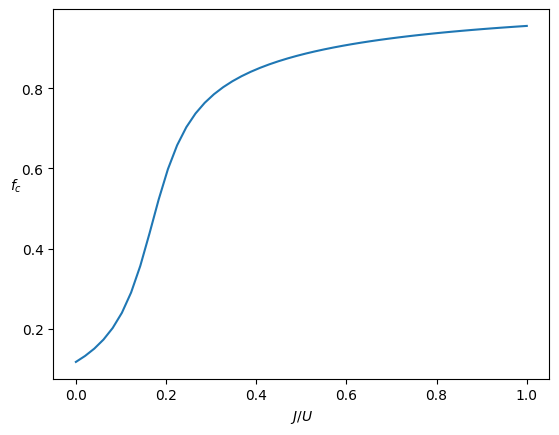

In [12]:
plt.plot(J_vals.get(), f_c.get())
plt.xlabel(r"$J/U$")
plt.ylabel(r"$f_c$", rotation=0)
plt.show()